[Hugging Face](https://huggingface.co/datasets/JST4/experiment-project-2)

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1mW3FK9rqU8YoxevWhhQlCj6SHPTb_R3e?usp=sharing

import warnings
warnings.filterwarnings("ignore")

Retrieving folder list
Processing file 1IzR-y7wkwSEl_ZEGSjTREH6uhGX61bNP BA_AirlineReviews_CL_excel.xlsx
Processing file 1J3H_UU7PbS1c5Rx1EWsobEYE5fHzzpL6 BA_AirlineReviews_DataDictionary.txt
Processing file 1wi1uzZyrbjwt9wR1b-QEwpd-cZoL-95B experiment.xlsx
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1IzR-y7wkwSEl_ZEGSjTREH6uhGX61bNP
To: /content/jst2/BA_AirlineReviews_CL_excel.xlsx
100% 1.65M/1.65M [00:00<00:00, 45.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1J3H_UU7PbS1c5Rx1EWsobEYE5fHzzpL6
To: /content/jst2/BA_AirlineReviews_DataDictionary.txt
100% 1.23k/1.23k [00:00<00:00, 4.49MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wi1uzZyrbjwt9wR1b-QEwpd-cZoL-95B
To: /content/jst2/experiment.xlsx
100% 25.1k/25.1k [00:00<00:00, 33.2MB/s]
Download completed


In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data Preprocessing

In [ ]:
import pandas as pd

df = pd.read_excel('/content/jst2/BA_AirlineReviews_CL_excel.xlsx', engine='openpyxl')
df.head()

,id,Satisfaction,ReviewHeader,Name,Datetime,VerifiedReview,ReviewBody,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity
0,0,Very Dissatisfied,"""Service level far worse then Ryanair""",L Keele,19th November 2023,True,4 Hours before takeoff we received a Mail stat...,Couple Leisure,Economy Class,London to Stuttgart,2023-11-01,1.0,1.0,1.0,1.0,no,NaN,NaN,NaN,NaN
1,1,Neutral,"""do not upgrade members based on status""",Austin Jones,19th November 2023,True,I recently had a delay on British Airways from...,Business,Economy Class,Brussels to London,2023-11-01,2.0,3.0,1.0,2.0,no,A320,1.0,2.0,2.0
2,2,Enthusiastic,"""Flight was smooth and quick""",M A Collie,16th November 2023,False,"Boarded on time, but it took ages to get to th...",Couple Leisure,Business Class,London Heathrow to Dublin,2023-11-01,3.0,3.0,4.0,3.0,yes,A320,4.0,NaN,NaN
3,3,Very Dissatisfied,"""Absolutely hopeless airline""",Nigel Dean,16th November 2023,True,"5 days before the flight, we were advised by B...",Couple Leisure,Economy Class,London to Dublin,2022-12-01,3.0,3.0,1.0,1.0,no,NaN,NaN,NaN,NaN
4,4,Very Dissatisfied,"""Customer Service is non existent""",Gaylynne Simpson,14th November 2023,False,"We traveled to Lisbon for our dream vacation, ...",Couple Leisure,Economy Class,London to Lisbon,2023-11-01,1.0,1.0,1.0,1.0,no,NaN,1.0,1.0,1.0


In [ ]:
df.isnull().sum()

id                          0
Satisfaction                0
ReviewHeader                0
Name                        0
Datetime                    0
VerifiedReview              0
ReviewBody                  0
TypeOfTraveller           771
SeatType                    2
Route                     775
DateFlown                 778
SeatComfort               116
CabinStaffService         127
GroundService             846
ValueForMoney               1
Recommended                 0
Aircraft                 1779
Food&Beverages            386
InflightEntertainment    1150
Wifi&Connectivity        3092
dtype: int64

(6190, 20) (1111, 20) (6190,) (1111,)


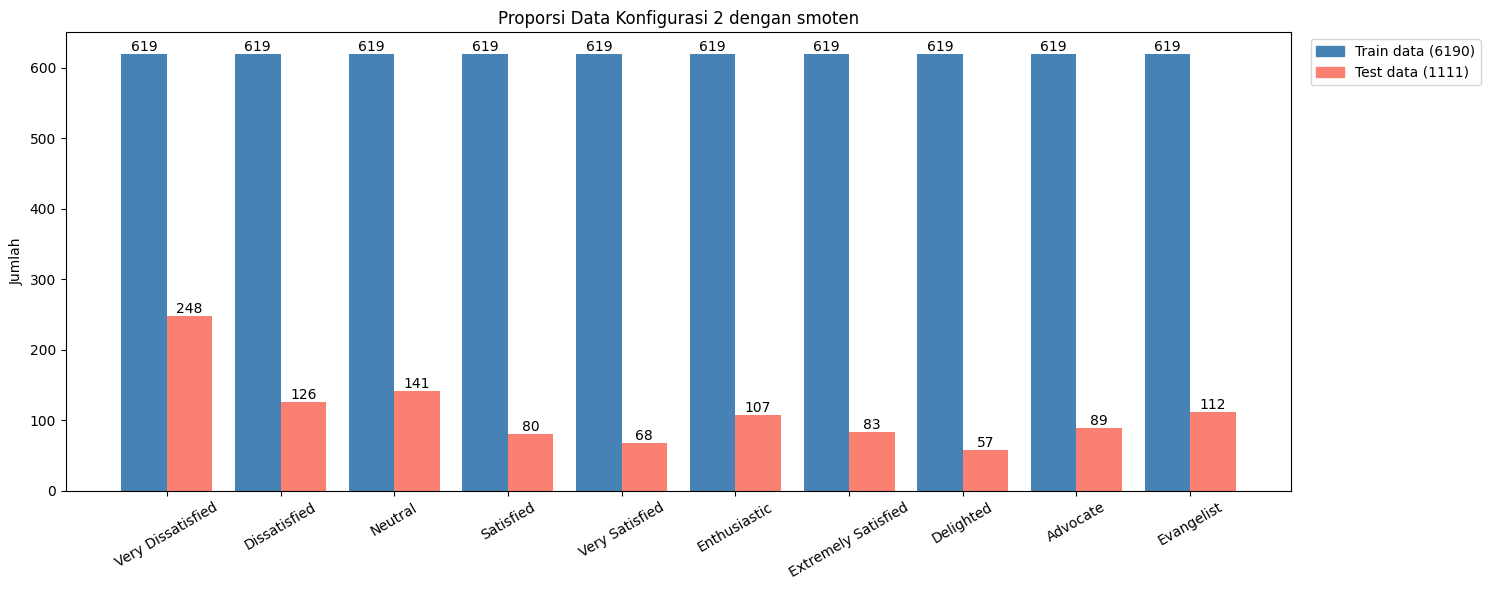

In [ ]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split



class AirlineReviews:
    def __init__(self, df):
        self.df = df
        self._y_train = None
        self._y_test = None
        self._data_version = None
        self._imbalance_class_method = None
        self.data_config = dict(
            Satisfaction = {
                0: 'Very Dissatisfied',
                1: 'Dissatisfied',
                2: 'Neutral',
                3: 'Satisfied',
                4: 'Very Satisfied',
                5: 'Enthusiastic',
                6: 'Extremely Satisfied',
                7: 'Delighted',
                8: 'Advocate',
                9: 'Evangelist'
            },
            SeatType = {
                0: 'Economy Class',
                1: 'Premium Economy',
                2: 'Business Class',
                3: 'First Class'
            }
        )

    def preporcessing(self, data_version, fillna_strategy='fbfill', use_scaler=True, imbalance_class_method=None):
        df_final = self.df.drop(
            ['ReviewHeader', 'Name', 'Route', 'ReviewBody', 'Aircraft', 'id'],
            axis=1
        )

        df_final['Datetime'] = df_final['Datetime'].apply(self._todate)
        df_final['DateFlown'].fillna(df_final['Datetime'] - (df_final['Datetime'] - df_final['DateFlown']).median(), inplace=True)
        df_final['DayTillReview'] = (df_final['Datetime'] - df_final['DateFlown']).apply(lambda x: x.days)
        df_final.drop(['Datetime', 'DateFlown'], inplace=True, axis=1)

        enc_cols = ['Satisfaction', 'SeatType']
        for col in enc_cols:
            encoded_col = f"{col}Encoded"
            df_final[encoded_col] = df_final[col].apply(lambda x: self._encode_level(x, col))
            df_final = df_final.drop(columns=[col])

        df_final = self._fillna(df_final, fillna_strategy)

        df_final['VerifiedReview'] = df_final['VerifiedReview'].astype(str)
        df_final = self._one_hot_encode(df_final, ['VerifiedReview', 'TypeOfTraveller', 'Recommended'])

        '''df_final['TypeOfTraveller_Business'] = (df_final['TypeOfTraveller_0'] + df_final['TypeOfTraveller_Business'])
        df_final['TypeOfTraveller_Couple Leisure'] = (df_final['TypeOfTraveller_1'] + df_final['TypeOfTraveller_Couple Leisure'])
        df_final['TypeOfTraveller_Solo Leisure'] = (df_final['TypeOfTraveller_3'] + df_final['TypeOfTraveller_Solo Leisure'])

        df_final.drop(['TypeOfTraveller_0', 'TypeOfTraveller_1', 'TypeOfTraveller_3'], axis=1, inplace=True)'''

        self.df = df_final

        X = self.df.drop(['SatisfactionEncoded'], axis=1).values
        y = self.df['SatisfactionEncoded'].values
        if use_scaler:
            from sklearn.preprocessing import StandardScaler, MinMaxScaler
            scaler = StandardScaler()
            X = scaler.fit_transform(X)

        train_size = {
            1: .5,
            2: .7,
            3: .9
        }

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size[data_version], random_state=42)
        if imbalance_class_method is not None:
            im = self._get_imbalace_class_method(imbalance_class_method)
            X_train, y_train = im.fit_resample(X_train, y_train)
            self._imbalance_class_method = imbalance_class_method

        self._y_train = y_train
        self._y_test = y_test
        self._data_version = data_version

        return X_train, X_test, y_train, y_test

    def _encode_level(self, level, col):
        for key, value in self.data_config[col].items():
            if level == value:
                return key

    def _todate(self, x):
        split_date = x.split(' ')
        split_date[0] = split_date[0].replace('th', '').replace('nd', '').replace('st', '').replace('rd', '')
        date = datetime.strptime(' '.join(split_date), '%d %B %Y')
        return date

    def _fillna(self, data, fillna_strategy='fbfill'):
        if fillna_strategy != 'fbfill':
            feature_cols = ['VerifiedReview', 'Recommended', 'SatisfactionEncoded']
            for col in data.columns:
                if data[col].isnull().sum() > 0:
                    # print(col)
                    target_col = col

                    not_null_idx = data[data[target_col].notnull()].index
                    null_idx = data[data[target_col].isnull()].index

                    data['VerifiedReview'] = data['VerifiedReview'].astype(str)
                    X = data[feature_cols].iloc[not_null_idx]
                    X_test = data[feature_cols].iloc[null_idx]

                    object_cols = []
                    for col in feature_cols:
                        if data[col].dtype == 'object':
                            object_cols.append(col)

                    X = self._one_hot_encode(X, object_cols)
                    X_test = self._one_hot_encode(X_test, object_cols)

                    y = data[target_col].iloc[not_null_idx]
                    le = LabelEncoder()
                    y = le.fit_transform(y)

                    classifier = self._get_classifier(fillna_strategy)
                    classifier.fit(X, y)


                    try:
                        y_pred = classifier.predict(X_test)
                    except:
                        continue

                    data[target_col].iloc[null_idx] = y_pred
                    # feature_cols.append(target_col)

        for col in data.columns:
            if data[col].isnull().any():
                data[col] = data[col].fillna(method='ffill')
                data[col] = data[col].fillna(method='bfill')
        return data

    def _one_hot_encode(self, data, cols):
        df_ohe = pd.get_dummies(data[cols])
        df_out = pd.concat([data.drop(cols, axis=1), df_ohe], axis=1)

        return df_out

    def _get_classifier(self, model_type):
        classifiers = {
            "knn": KNeighborsClassifier(n_neighbors=5, weights='uniform'),
            "rf": RandomForestClassifier(n_estimators=100, max_features='auto'),
            "adb": AdaBoostClassifier(n_estimators=50),
            "gb": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
            "nb": GaussianNB(),
            "lr": LogisticRegression(C=1.0, solver='liblinear'),
            "dt": DecisionTreeClassifier(max_depth=10),
            "svm": SVC(C=1.0, kernel='rbf', gamma='auto'),
            "lsvm": LinearSVC(C=1.0),
            "xgb": xgb.XGBClassifier(n_estimators=100)
        }

        if model_type in classifiers:
            return classifiers[model_type]


    def _get_imbalace_class_method(self, method):
        import imblearn
        oversampling_methods = {
            'smote': imblearn.over_sampling.SMOTE(sampling_strategy='auto', random_state=42),
            'smotenc': imblearn.over_sampling.SMOTENC(categorical_features='auto', random_state=42),
            'smoten': imblearn.over_sampling.SMOTEN(sampling_strategy='auto', random_state=42),
            'adasyn': imblearn.over_sampling.ADASYN(sampling_strategy='auto'),
            'borderline_smote': imblearn.over_sampling.BorderlineSMOTE(sampling_strategy='auto', random_state=42),
            'kmeanssmote': imblearn.over_sampling.KMeansSMOTE(sampling_strategy='auto', random_state=42),
            'svmsmote': imblearn.over_sampling.SVMSMOTE(sampling_strategy='auto', random_state=42)
        }

        if method in oversampling_methods:
            return oversampling_methods[method]


    def proporsi(self):
        proporsi = dict(train = {}, test = {})

        for cls in np.unique(self._y_train):
            proporsi['train'][self.data_config['Satisfaction'][cls]] = (self._y_train == cls).sum()
            proporsi['test'][self.data_config['Satisfaction'][cls]] = (self._y_test == cls).sum()

        classes = list(proporsi['train'].keys())
        x = np.arange(len(classes))
        width = 0.4

        fig, ax = plt.subplots(figsize=(15, 6))
        for i, dataset in enumerate(['train', 'test']):
            counts = list(proporsi[dataset].values())
            bars = ax.bar(x + i*width, counts, width, label=dataset, color='steelblue' if dataset == 'train' else 'salmon')
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

        ax.set_xticks(x + (width/2))
        ax.set_xticklabels(classes, rotation=30)
        ax.set_ylabel('Jumlah')
        if self._imbalance_class_method is not None:
            ax.set_title(f'Proporsi Data Konfigurasi {self._data_version} dengan {self._imbalance_class_method}')
        else:
            ax.set_title(f'Proporsi Data Konfigurasi {self._data_version}')

        train_c = mpatches.Patch(color='steelblue', label=f'Train data ({len(self._y_train)})')
        test_c = mpatches.Patch(color='salmon', label=f'Test data ({len(self._y_test)})')
        ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', handles=[train_c, test_c])

        fig.tight_layout()
        plt.show()

    def as_df(self):
        return self.df

data = AirlineReviews(df)
X_train, X_test, y_train, y_test = data.preporcessing(2, 'knn', use_scaler=True, imbalance_class_method='smoten')
data_df = data.as_df()
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
data.proporsi()

## MLP

In [ ]:
import torch
from torch import nn
from typing import Union, List

class MLP(nn.Module):
    def __init__(self, in_features: int, hidden: Union[int, List], out_features: int):
        super(MLP, self).__init__()
        self.hidden = [hidden] if type(hidden) == int else hidden
        self.inp = nn.Linear(in_features, self.hidden[0])
        self.hidden_layers = nn.ModuleList(
            [
                nn.Linear(j, self.hidden[i-len(self.hidden)+1])
                for i, j in enumerate(self.hidden)
            ]
        )
        self.clf = nn.Linear(self.hidden[0], out_features)
        self.act_fn = nn.ReLU()
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        x = self.act_fn(self.inp(x))
        for h in self.hidden_layers:
            x = self.act_fn(h(x))
        x = self.clf(x)
        return self.softmax(x)

mlp = MLP(20, [32], 10)
mlp

MLP(
  (inp): Linear(in_features=20, out_features=32, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
  )
  (clf): Linear(in_features=32, out_features=10, bias=True)
  (act_fn): ReLU()
  (softmax): Softmax(dim=1)
)

In [ ]:
!pip install torchinfo -q

In [ ]:
from torchinfo import summary

summary(mlp, input_size=[16, 20], col_names=["input_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Param #
MLP                                      [16, 20]                  --
├─Linear: 1-1                            [16, 20]                  672
├─ReLU: 1-2                              [16, 32]                  --
├─ModuleList: 1-3                        --                        --
│    └─Linear: 2-1                       [16, 32]                  1,056
├─ReLU: 1-4                              [16, 32]                  --
├─Linear: 1-5                            [16, 32]                  330
├─Softmax: 1-6                           [16, 10]                  --
Total params: 2,058
Trainable params: 2,058
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02

In [ ]:
import torch
import torch.nn as nn
import os
import shutil

from tqdm.auto import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

import matplotlib.pyplot as plt

def save_plot(result, metric, ylabel, save_as, dir):
    plt.plot(result[f'train_{metric}'], label='Train ' + ylabel)
    plt.plot(result[f'test_{metric}'], label='Test ' + ylabel)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.savefig(f'{dir}/{save_as}.jpg', format='jpg')
    plt.close()

def get_optimizer(model, optimizer_name, lr=0.001, weight_decay=0.0001):
    optimizer_dict = {
        'adam': lambda params, lr: optim.Adam(params, lr=lr, weight_decay=weight_decay),
        'adagrad': lambda params, lr: optim.Adagrad(params, lr=lr, weight_decay=weight_decay),
        'rmsprop': lambda params, lr: optim.RMSprop(params, lr=lr, weight_decay=weight_decay),
        'adadelta': lambda params, lr: optim.Adadelta(params, lr=lr, weight_decay=weight_decay),
        'adamw': lambda params, lr: optim.AdamW(params, lr=lr, weight_decay=weight_decay),
        'nadam': lambda params, lr: optim.NAdam(params, lr=lr, weight_decay=weight_decay),
        'radam': lambda params, lr: optim.RAdam(params, lr=lr, weight_decay=weight_decay)
    }

    return optimizer_dict[optimizer_name](model.parameters(), lr)

def get_dataloaders(X_train, y_train, X_test, y_test, batch_size=64, shuffle_train=True):

    train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=shuffle_train,
        num_workers=os.cpu_count()
    )

    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        num_workers=os.cpu_count()
    )

    return train_dataloader, test_dataloader


def train_model(model, train_dataloader, test_dataloader, loss_fn, optimizer, scheduler, device, epochs=50):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    params = sum(p.numel() for p in model.parameters())
    print(f"Total parameter: {params:_}")
    model.to(device)
    try:
        os.makedirs('model')
    except:
        shutil.rmtree('model')
        os.makedirs('model')

    result = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    def print_progress(epoch, train_loss, train_acc, test_loss, test_acc):
        print(f'Epoch {epoch}:',
              f'Training Loss: {train_loss:.4f}',
              f'Training Accuracy: {100 * train_acc:.2f}%',
              f'Test Loss: {test_loss:.4f}',
              f'Test Accuracy: {100 * test_acc:.2f}%')

    def calculate_accuracy(logits, y):
        predictions = torch.argmax(logits, dim=1)
        acc = ((predictions == y).sum() / y.shape[0]).item()
        return acc

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = 0, 0
        model.train()

        for X, y in train_dataloader:
            X, y = X.to(device), y.type(torch.LongTensor).to(device)

            optimizer.zero_grad()
            logits = model(X)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()

            train_acc += calculate_accuracy(logits, y)
            train_loss += loss.item()

        test_loss, test_acc = 0, 0
        model.eval()

        with torch.inference_mode():
            for X_test, y_test in test_dataloader:
                X_test, y_test = X_test.to(device), y_test.type(torch.LongTensor).to(device)

                logits = model(X_test)
                test_loss += loss_fn(logits, y_test).item()
                test_acc += calculate_accuracy(logits, y_test)

        scheduler.step()

        result['train_loss'].append(train_loss / len(train_dataloader))
        result['train_acc'].append(train_acc / len(train_dataloader))
        result['test_loss'].append(test_loss / len(test_dataloader))
        result['test_acc'].append(test_acc / len(test_dataloader))

        torch.save(model.state_dict(), f'model/mlp-{epoch+1}.pth')

        if (epoch + 1) % 5 == 0:
            print_progress(epoch + 1, result['train_loss'][-1], result['train_acc'][-1], result['test_loss'][-1], result['test_acc'][-1])

    return result

## Eksperimen

[link hf_token](https://huggingface.co/settings/tokens) pilih yang write

In [ ]:
import json
from huggingface_hub import login, HfApi

torch.cuda.manual_seed(1)
torch.manual_seed(1)


hf_token = '' #klik link atas itu
data_version = 3 # 1, 2, 3
fillna_strategy = 'fbfill' # fbfill, knn, rf, adb, gb, nb, lr, dt, svm, lsvm, xgb
use_scaler = True # True, False
imbalance_class_method = None # None, smote, smotenc, smoten, adasyn, borderline_smote, kmeanssmote, svmsmote
batch_size = 64 # 16, 32, 64, 128
hidden = [16, 32] # terserah contoh: [16], [16, 32], [32, 128, 256]
optimizer = 'adamw'
learning_rate = 0.0001 # terserah
weight_decay=0.0001 # terserah
lr_scheduler_step = 30 # 10, 20, 25, 30, 50
epochs=100


# =============================================================================================

device = 'cuda' if torch.cuda.is_available() else 'cpu'
data = AirlineReviews(df)
X_train, X_test, y_train, y_test = data.preporcessing(data_version, fillna_strategy, use_scaler=use_scaler, imbalance_class_method=imbalance_class_method)
train_dataloader, test_dataloader = get_dataloaders(X_train, y_train, X_test, y_test, batch_size=batch_size)

model = MLP(in_features=X_train.shape[1], hidden=hidden, out_features=10).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = get_optimizer(model, optimizer, lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_scheduler_step, gamma=0.1)

result = train_model(model, train_dataloader, test_dataloader, loss_fn, optimizer, scheduler, device, epochs=epochs)

config = {
    'data_version': data_version,
    'fillna_strategy': fillna_strategy,
    'use_scaler': use_scaler,
    'imbalance_class_method': imbalance_class_method,
    'hidden_layers': hidden,
    'loss_function': loss_fn.__class__.__name__,
    'optimizer': optimizer.__class__.__name__,
    'batch_size': batch_size,
    'epochs': epochs,
    'learning_rate': optimizer.param_groups[0]['lr'],
    'weight_decay': optimizer.param_groups[0]['weight_decay'],
    'lr_scheduler_step': scheduler.step_size
}

best_train = (np.array(result['train_acc']) - np.array(result['train_loss']))
best_test = (np.array(result['test_acc']) - np.array(result['test_loss']))
best_model = np.argmax(best_train + best_train, axis=0) + 1


dir = f'/content/experiment/' + '/'.join([f'{k}_{v}' for k, v in config.items()])
os.makedirs(dir, exist_ok=True)
save_plot(result, 'loss', 'Loss', 'loss', dir)
save_plot(result, 'acc', 'Accuracy', 'accuracy', dir)

shutil.copy(f'model/mlp-{best_model}.pth', dir)

with open(f'{dir}/result.json', 'w') as f:
    json.dump(result, f)

with open(f'{dir}/config.json', 'w') as f:
    json.dump(config, f)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

inp = torch.Tensor(X_test)
model.cpu()
with torch.no_grad():
    out = model(inp).argmax(1).detach().numpy()

metric = dict(
    accuracy_score = accuracy_score(y_test, out),
    precision = precision_score(y_test, out, average='weighted'),
    recal = recall_score(y_test, out, average='weighted'),
    f1 = f1_score(y_test, out, average='weighted')
)

with open(f'{dir}/metric.json', 'w') as f:
    json.dump(metric, f)

login(hf_token, add_to_git_credential=True)

In [ ]:
from huggingface_hub import login, HfApi

api = HfApi()
api.upload_folder(
    folder_path='experiment',
    repo_id="JST4/experiment-project-2",
    repo_type="dataset",
)

'https://huggingface.co/datasets/JST4/experiment-project-2/tree/main/'

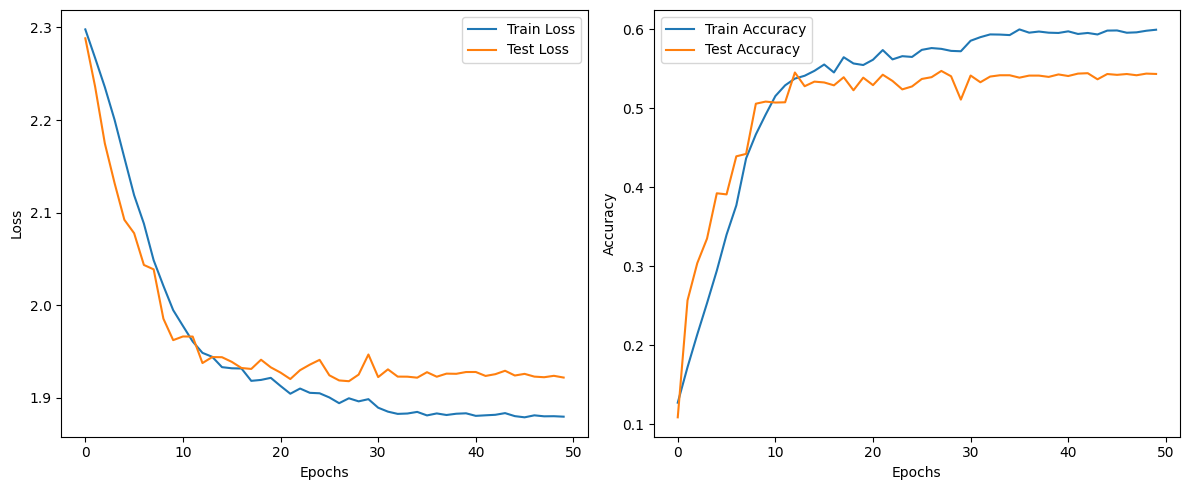

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(result["train_loss"], label="Train Loss")
axs[0].plot(result["test_loss"], label="Test Loss")
axs[0].legend()
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")

axs[1].plot(result["train_acc"], label="Train Accuracy")
axs[1].plot(result["test_acc"], label="Test Accuracy")
axs[1].legend()
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

## Jangan dirun

In [ ]:
from google.colab import userdata
from huggingface_hub import login, HfApi

login(userdata.get('hf_token'), add_to_git_credential=True)

Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
import os
import transformers
from huggingface_hub import snapshot_download

transformers.utils.logging.disable_progress_bar()
repo_id = "JST4/experiment-project-2"

expe_dir = snapshot_download(repo_id=repo_id, repo_type="dataset", local_dir='/content/experiment')

In [ ]:
import json
import numpy as np
import pandas as pd
import shutil
import os
import itertools
from tqdm.auto import tqdm
from urllib.parse import quote

torch.cuda.manual_seed(1)
torch.manual_seed(1)


best_results = []
expe_dir = '/content/experiment/'

for dir in os.walk(expe_dir):
    if ('lr_scheduler_step' in dir[0]):
        url_repo = 'https://huggingface.co/datasets/JST4/experiment-project-2/tree/main/'

        with open(f'{dir[0]}/result.json', 'r') as f:
            res = json.load(f)

        with open(f'{dir[0]}/config.json', 'r') as f:
            conf = json.load(f)

        best_train = (np.array(res['train_acc']) - np.array(res['train_loss']))
        best_test = (np.array(res['test_acc']) - np.array(res['test_loss']))
        best_at_epoch = np.argmax(best_train + best_train, axis=0) + 1

        repo = dir[0].split('/')[3:]
        for i in range(len(repo)):
            if '[' in repo[i]:
                enc = '_'.join(repo[i].split('_')[:2]) + '_' + quote(repo[i].split('_')[-1])
                repo[i] = enc

        url_repo += '/'.join(repo)
        url_repo = f'=HYPERLINK("{url_repo}","repo")'
        data = AirlineReviews(df)
        data_args = dict(itertools.islice(conf.items(), 4))
        X_train, X_test, y_train, y_test = data.preporcessing(**data_args)

        model = MLP(in_features=X_train.shape[1], hidden=conf['hidden_layers'], out_features=10).to(device)
        model.load_state_dict(torch.load(f'{dir[0]}/mlp-{best_at_epoch}.pth'))

        inp = torch.Tensor(X_test)
        model.cpu()
        with torch.inference_mode():
            out = model(inp).argmax(1).detach().numpy()

        metric = dict(
            accuracy = accuracy_score(y_test, out),
            precision = precision_score(y_test, out, average='weighted'),
            recal = recall_score(y_test, out, average='weighted'),
            f1 = f1_score(y_test, out, average='weighted')
        )

        res_copy = {k:res[k][best_at_epoch-1] for k, _ in res.items()}
        res_copy['best_at_epoch'] = best_at_epoch
        res_copy['score'] = (res_copy['train_acc'] + res_copy['test_acc'] + sum(metric.values())) / 6

        conf.update(res_copy)
        conf.update(metric)
        conf.update({'url_repo': url_repo})
        best_results.append(conf)


df_res = pd.DataFrame(best_results)
df_res.sort_values('score', ascending=False, inplace=True, ignore_index=True)

pow = (df_res['epochs'] // df_res['lr_scheduler_step'] - 1)
pow[pow < 0] = 0
df_res['learning_rate'] = np.abs(df_res['learning_rate'] * (10 ** pow))
df_res

,data_version,fillna_strategy,use_scaler,imbalance_class_method,hidden_layers,loss_function,optimizer,batch_size,epochs,learning_rate,...,train_acc,test_loss,test_acc,best_at_epoch,score,accuracy,precision,recal,f1,url_repo
0,1,knn,True,smoten,[32],CrossEntropyLoss,RMSprop,16,70,0.000300,...,0.824285,1.855649,0.604085,68,0.637281,0.603998,0.592753,0.603998,0.594567,"=HYPERLINK(""https://huggingface.co/datasets/JS..."
1,1,knn,True,smoten,[16],CrossEntropyLoss,RMSprop,16,70,0.000300,...,0.782086,1.857313,0.607318,61,0.631110,0.607239,0.588223,0.607239,0.594556,"=HYPERLINK(""https://huggingface.co/datasets/JS..."
2,3,knn,True,smote,"[16, 32]",CrossEntropyLoss,Adam,32,50,0.000500,...,0.725673,1.847597,0.611705,50,0.627240,0.609164,0.608241,0.609164,0.599491,"=HYPERLINK(""https://huggingface.co/datasets/JS..."
3,1,knn,True,borderline_smote,[32],CrossEntropyLoss,RMSprop,64,70,0.000300,...,0.788658,1.872988,0.583230,64,0.622264,0.582928,0.607873,0.582928,0.587967,"=HYPERLINK(""https://huggingface.co/datasets/JS..."
4,1,knn,True,smoten,[32],CrossEntropyLoss,RMSprop,64,100,0.000300,...,0.784808,1.867691,0.591175,79,0.620291,0.591032,0.583908,0.591032,0.579789,"=HYPERLINK(""https://huggingface.co/datasets/JS..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2,knn,True,adasyn,"[32, 64]",CrossEntropyLoss,AdamW,64,100,0.000001,...,0.217569,2.198980,0.318048,48,0.259562,0.310531,0.202359,0.310531,0.198334,"=HYPERLINK(""https://huggingface.co/datasets/JS..."
126,1,knn,False,borderline_smote,"[32, 128, 256]",CrossEntropyLoss,Adam,128,70,0.003000,...,0.320344,2.172768,0.274850,6,0.239932,0.274986,0.126705,0.274986,0.167719,"=HYPERLINK(""https://huggingface.co/datasets/JS..."
127,3,xgb,True,kmeanssmote,"[16, 32, 128, 256]",CrossEntropyLoss,AdamW,32,100,0.001000,...,0.353060,2.213565,0.244243,1,0.225416,0.239892,0.120799,0.239892,0.154610,"=HYPERLINK(""https://huggingface.co/datasets/JS..."
128,1,gb,False,smote,[32],CrossEntropyLoss,Adadelta,128,70,0.000300,...,0.135268,2.310026,0.101139,66,0.084704,0.100486,0.031217,0.100486,0.039625,"=HYPERLINK(""https://huggingface.co/datasets/JS..."


In [ ]:
df_res.to_excel('/content/drive/MyDrive/Colab Notebooks/jst2/experiment.xlsx')

In [ ]:
!pip install datasets -q

In [ ]:
from datasets import Dataset, DatasetDict

dataset_hf = Dataset.from_pandas(df_res, split='result')
dataset_hf.push_to_hub(repo_id)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
from sklearn.metrics import mean_squared_error
import pprint

best_dir = '/content/experiment/data_version_1/fillna_strategy_knn/use_scaler_True/imbalance_class_method_smoten/hidden_layers_[32]/loss_function_CrossEntropyLoss/optimizer_RMSprop/batch_size_16/epochs_70/learning_rate_3.0000000000000005e-06/weight_decay_1e-05/lr_scheduler_step_20'

with open(f'{best_dir}/config.json', 'r') as f:
    conf = json.load(f)

data = AirlineReviews(df)
data_args = dict(itertools.islice(conf.items(), 4))
X_train, X_test, y_train, y_test = data.preporcessing(**data_args)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model = MLP(in_features=X_train.shape[1], hidden=conf['hidden_layers'], out_features=10).to(device)
model.load_state_dict(torch.load(f'{best_dir}/mlp-68.pth'))

inp = torch.Tensor(X_test)
model.cpu()
with torch.inference_mode():
    out = model(inp).argmax(1).detach().numpy()

metric = dict(
    mse = mean_squared_error(y_test, out),
    accuracy = accuracy_score(y_test, out),
    precision = precision_score(y_test, out, average='weighted'),
    recal = recall_score(y_test, out, average='weighted'),
    f1 = f1_score(y_test, out, average='weighted')
)

pprint.pprint(metric)

{'accuracy': 0.6039978390059427,
 'f1': 0.5945666616368186,
 'mse': 2.1026472177201514,
 'precision': 0.5927526289548304,
 'recal': 0.6039978390059427}
